## 난임 환자 대상 임신 성공 여부 예측

### LGAimers 6th 온라인 해커톤

Import

In [5]:
import pandas as pd
import lightgbm as lgb
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier

### Data Load

In [6]:
# 데이터 로드
IVF_train = pd.read_csv('../data/IVF_train_dataset_24.csv')
IVF_test = pd.read_csv('../data/IVF_test_dataset_24.csv')

DI_train = pd.read_csv('../data/DI_train_dataset_24.csv')
DI_test = pd.read_csv('../data/DI_test_dataset_24.csv')

In [3]:
IVF_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250052 entries, 0 to 250051
Data columns (total 92 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   ID                      250052 non-null  object 
 1   시술_시기_코드                250052 non-null  object 
 2   시술_당시_나이                250052 non-null  object 
 3   임신_시도_또는_마지막_임신_경과_연수   250052 non-null  object 
 4   배란_자극_여부                250052 non-null  int64  
 5   배란_유도_유형                250052 non-null  object 
 6   단일_배아_이식_여부             250052 non-null  float64
 7   착상_전_유전_검사_사용_여부        250052 non-null  float64
 8   착상_전_유전_진단_사용_여부        250052 non-null  float64
 9   남성_주_불임_원인              250052 non-null  int64  
 10  남성_부_불임_원인              250052 non-null  int64  
 11  여성_주_불임_원인              250052 non-null  int64  
 12  여성_부_불임_원인              250052 non-null  int64  
 13  부부_주_불임_원인              250052 non-null  int64  
 14  부부_부_불임_원인          

In [4]:
DI_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6290 entries, 0 to 6289
Data columns (total 36 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   ID                     6290 non-null   object 
 1   시술_시기_코드               6290 non-null   object 
 2   시술_당시_나이               6290 non-null   object 
 3   임신_시도_또는_마지막_임신_경과_연수  6290 non-null   object 
 4   배란_자극_여부               6290 non-null   int64  
 5   남성_주_불임_원인             6290 non-null   int64  
 6   남성_부_불임_원인             6290 non-null   int64  
 7   여성_주_불임_원인             6290 non-null   int64  
 8   여성_부_불임_원인             6290 non-null   int64  
 9   부부_주_불임_원인             6290 non-null   int64  
 10  부부_부_불임_원인             6290 non-null   int64  
 11  불명확_불임_원인              6290 non-null   int64  
 12  불임_원인_-_난관_질환          6290 non-null   int64  
 13  불임_원인_-_남성_요인          6290 non-null   int64  
 14  불임_원인_-_배란_장애          6290 non-null   int64  
 15  불임_원

In [9]:
# ID 열을 제외한 특성과 타겟 변수 분리
IVF_X = IVF_train.drop(['임신_성공_여부', 'ID'], axis=1)
IVF_y = IVF_train['임신_성공_여부']

DI_X = DI_train.drop(['임신_성공_여부', 'ID'], axis=1)
DI_y = DI_train['임신_성공_여부']

### 인코딩 

In [10]:
IVF_categorical_columns = [
    "시술_시기_코드",
    "시술_당시_나이",
    "임신_시도_또는_마지막_임신_경과_연수",
    "배란_유도_유형",
    "배아_생성_주요_이유",
    "난자_출처",
    "정자_출처",
    "난자_기증자_나이",
    "정자_기증자_나이",
    "변환된_특정_시술_유형",
    "채취_해동_차이",
    "해동_혼합_차이",
    "혼합_이식_차이",
    "이식_해동_차이"
]

In [11]:
DI_categorical_columns = [
    "시술_시기_코드",
    "시술_당시_나이",
    "임신_시도_또는_마지막_임신_경과_연수",
    "정자_기증자_나이",
    "변환된_특정_시술_유형"
]

In [12]:
# 모든 범주형 변수를 문자열로 변환
IVF_X[IVF_categorical_columns] = IVF_X[IVF_categorical_columns].astype(str)
DI_X[DI_categorical_columns] = DI_X[DI_categorical_columns].astype(str)
IVF_test[IVF_categorical_columns] = IVF_test[IVF_categorical_columns].astype(str)
DI_test[DI_categorical_columns] = DI_test[DI_categorical_columns].astype(str)

# OrdinalEncoder를 사용하여 범주형 변수 인코딩
IVF_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
DI_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

IVF_X[IVF_categorical_columns] = IVF_encoder.fit_transform(IVF_X[IVF_categorical_columns])
DI_X[DI_categorical_columns] = DI_encoder.fit_transform(DI_X[DI_categorical_columns])
IVF_test[IVF_categorical_columns] = IVF_encoder.transform(IVF_test[IVF_categorical_columns])
DI_test[DI_categorical_columns] = DI_encoder.transform(DI_test[DI_categorical_columns])

## Modeling

In [13]:
# 데이터 분할
IVF_X_train, IVF_X_test, IVF_y_train, IVF_y_test = train_test_split(IVF_X, IVF_y, test_size=0.2, random_state=42)
DI_X_train, DI_X_test, DI_y_train, DI_y_test = train_test_split(DI_X, DI_y, test_size=0.2, random_state=42)

### IVF 데이터


--- Model Performance ---
Model Accuracy: 0.7457159424926516
Model F1 Score: 0.19913092764027962
Model AUC: 0.7402425476074648


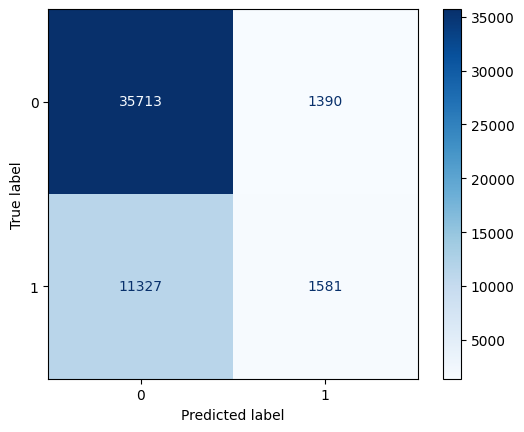

In [14]:
# 모델 초기화
IVF_model = lgb.LGBMClassifier(
    n_estimators=4471,
    num_leaves=13,
    max_depth=279,
    learning_rate=0.007075124517450591,
    min_child_samples=26,
    subsample=0.29772991936701476,
    colsample_bytree=0.8913054521763838,
    reg_alpha=0.0004860363321690653,
    reg_lambda=311.08056657247363,
    min_split_gain=0.18214905183450955,
    random_state=42,
    boosting_type='gbdt',
    verbose=-1
)

# 모델 학습
IVF_model.fit(IVF_X_train, IVF_y_train)

# 예측
y_pred = IVF_model.predict(IVF_X_test)
y_pred_proba = IVF_model.predict_proba(IVF_X_test)[:, 1]

# 평가
accuracy = accuracy_score(IVF_y_test, y_pred)
f1 = f1_score(IVF_y_test, y_pred)
auc = roc_auc_score(IVF_y_test, y_pred_proba)
cm = confusion_matrix(IVF_y_test, y_pred)

# 결과 출력
print()
print("--- Model Performance ---")
print(f"Model Accuracy: {accuracy}")
print(f"Model F1 Score: {f1}")
print(f"Model AUC: {auc}")

# 혼동 행렬 출력
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=IVF_model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()

### DI 데이터


--- Model Performance ---
Model Accuracy: 0.8664546899841018
Model F1 Score: 0.0
Model AUC: 0.7021788990825688


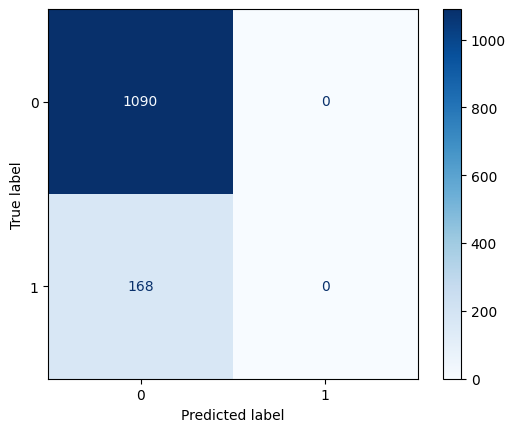

In [15]:
# 모델 초기화
DI_model = lgb.LGBMClassifier(
    n_estimators=1816,
    num_leaves=3926,
    max_depth=259,
    learning_rate=0.00238377640011148,
    min_child_samples=1,
    subsample=0.7610056627240331,
    colsample_bytree=0.6655579164853634,
    reg_alpha=0.00025227758337188327,
    reg_lambda=76.744107215122684,
    min_split_gain=0.007773520329665474,
    random_state=42,
    boosting_type='gbdt',
    verbose=-1
)

# 모델 학습
DI_model.fit(DI_X_train, DI_y_train)

# 예측
y_pred = DI_model.predict(DI_X_test)
y_pred_proba = DI_model.predict_proba(DI_X_test)[:, 1]

# 평가
accuracy = accuracy_score(DI_y_test, y_pred)
f1 = f1_score(DI_y_test, y_pred)
auc = roc_auc_score(DI_y_test, y_pred_proba)
cm = confusion_matrix(DI_y_test, y_pred)

# 결과 출력
print()
print("--- Model Performance ---")
print(f"Model Accuracy: {accuracy}")
print(f"Model F1 Score: {f1}")
print(f"Model AUC: {auc}")

# 혼동 행렬 출력
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=DI_model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()


--- Model Performance ---
Model Accuracy: 0.7486785386880961
Model F1 Score: 0.197046176855487
Model AUC: 0.7418487547231275


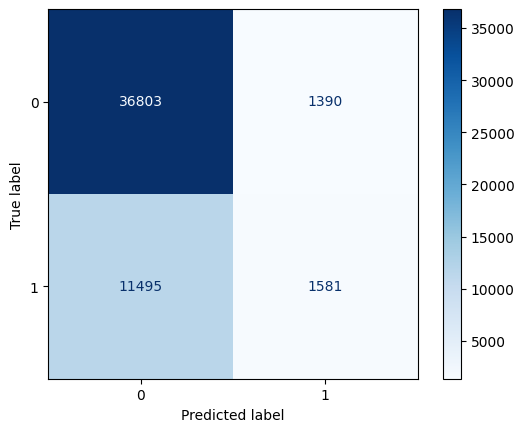

In [16]:
# 예측
IVF_y_pred = IVF_model.predict(IVF_X_test)
IVF_y_pred_proba = IVF_model.predict_proba(IVF_X_test)[:, 1]

DI_y_pred = DI_model.predict(DI_X_test)
DI_y_pred_proba = DI_model.predict_proba(DI_X_test)[:, 1]

# 예측 결과 병합
y_test = pd.concat([IVF_y_test, DI_y_test])
y_pred = pd.concat([pd.Series(IVF_y_pred, index=IVF_y_test.index), pd.Series(DI_y_pred, index=DI_y_test.index)])
y_pred_proba = pd.concat([pd.Series(IVF_y_pred_proba, index=IVF_y_test.index), pd.Series(DI_y_pred_proba, index=DI_y_test.index)])

# 평가
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_proba)
cm = confusion_matrix(y_test, y_pred)

# 결과 출력
print()
print("--- Model Performance ---")
print(f"Model Accuracy: {accuracy}")
print(f"Model F1 Score: {f1}")
print(f"Model AUC: {auc}")

# 혼동 행렬 출력
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=IVF_model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()

## 제출

In [17]:
# 모델 학습 및 예측
IVF_model.fit(IVF_X, IVF_y)
IVF_pred_proba = IVF_model.predict_proba(IVF_test.drop('ID', axis=1))[:, 1]

DI_model.fit(DI_X, DI_y)
DI_pred_proba = DI_model.predict_proba(DI_test.drop('ID', axis=1))[:, 1]

In [18]:
# 예측 결과 병합
IVF_test['probability'] = IVF_pred_proba
DI_test['probability'] = DI_pred_proba

# 최종 제출 파일 생성
submission = pd.concat([IVF_test[['ID', 'probability']], DI_test[['ID', 'probability']]], axis=0)
submission = submission.sort_values(by='ID')  

# 제출 파일 저장
submission.to_csv('../submission/code24_submit.csv', index=False, encoding='utf-8')

.